In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
x = torch.randn(3, requires_grad=True) # whenever operations are done using this tensor, pytorch will make a computational graph 
x

tensor([0.9478, 1.2474, 1.3238], requires_grad=True)

In [3]:
y = x + 2

The computational graph is now 

![](.md_images/2022-02-05-16-37-49.png)

```
x \
    +  =  y
2 /
```

When the summation operation is done, there will be a gradient function `grad_fn` avaliable, which can be seen in the next cell

In [4]:
y

tensor([2.9478, 3.2474, 3.3238], grad_fn=<AddBackward0>)

In [5]:
z = y * y * 2
z

tensor([17.3791, 21.0913, 22.0959], grad_fn=<MulBackward0>)

In [6]:
z = z.mean()
z

tensor(20.1888, grad_fn=<MeanBackward0>)

In [7]:
# The only thing we need to calculate the gradient is .backward()
z.backward() # calculates the gradient dz/dx, as z depends on y and y depends on x
print(x.grad) # in the background this creates a vector Jakobian product to get the gradients

tensor([3.9304, 4.3299, 4.4318])


The vector Jakobian matrix:

![](.md_images/2022-02-05-16-48-31.png)

If z is not a scalar, then we must give z.backwar() a vector of teh same size of z as arguemnt. Though the loss function ususally has a single scalar value for its output. 

In [8]:
z = y * y * 2
print(z)
v = torch.tensor([0.1,1.0,0.001], dtype=torch.float32)
z.backward(v)
print(x.grad)

tensor([17.3791, 21.0913, 22.0959], grad_fn=<MulBackward0>)
tensor([ 5.1095, 17.3195,  4.4451])


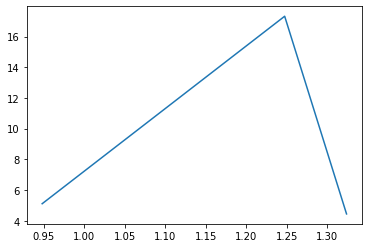

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(x.detach(), x.grad.detach())

In [10]:
# Information from https://www.youtube.com/watch?v=M0fX15_-xrY
import torch
import torch.nn as nn

BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()
model

TinyModel(
  (layer1): Linear(in_features=1000, out_features=100, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=100, out_features=10, bias=True)
)

In [11]:
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad)

tensor([-0.0660, -0.0286, -0.0124, -0.0448, -0.0034,  0.0432, -0.0301,  0.0754,
         0.0533,  0.0261], grad_fn=<SliceBackward0>)
None


In [12]:
optimiser = torch.optim.SGD(model.parameters(), lr=0.001) # the optimiser is responsible for adjusting the weights. model.parameters() are the weights

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
loss

tensor(172.1098, grad_fn=<SumBackward0>)

In [13]:
loss.backward() # this does not change the weights, but it computes gradients
print(model.layer2.weight.grad) # after calling .backward() this is now populated (used to be "none")

tensor([[-1.7701e+00,  1.6638e+00, -8.1883e-01,  3.0747e+00, -9.7596e-02,
          1.1499e+00,  6.3433e-01, -1.0187e+00, -2.6175e+00, -1.4519e+00,
          4.5643e-01, -1.4644e+00, -2.4255e+00,  2.6985e-01,  3.1476e+00,
         -8.8200e-01, -2.1003e-01, -6.3955e-01,  1.1261e+00, -2.2280e+00,
          4.9854e-01, -9.4888e-01,  3.9972e-01, -2.5047e+00, -1.3480e+00,
         -2.2966e+00, -8.7272e-01, -1.5762e+00, -2.3289e+00, -7.5630e-01,
         -1.3897e+00, -1.0016e+00,  5.0188e-01,  4.3958e-01, -2.4936e-03,
          1.5737e+00, -8.0517e-01, -2.0990e-01, -1.5634e+00, -3.4382e+00,
         -4.5506e-01, -2.0725e+00,  8.7222e-01, -1.5890e+00, -7.8006e-02,
         -2.1267e-01, -9.4774e-01,  1.6245e+00,  1.0315e+00,  5.2008e-01,
          3.5028e+00, -1.5476e+00, -1.4709e+00, -8.7902e-01, -2.7155e+00,
         -2.1635e+00, -3.2861e+00, -1.5005e+00, -9.0619e-01, -2.9491e+00,
         -2.0101e+00,  7.9420e-01, -2.2553e-01,  1.1952e+00, -4.8266e+00,
          1.6508e+00,  5.3247e-01, -4.

In [14]:
print(model.layer2.weight[0][0:10]) # the weights are still not changed, as can be seen

tensor([-0.0660, -0.0286, -0.0124, -0.0448, -0.0034,  0.0432, -0.0301,  0.0754,
         0.0533,  0.0261], grad_fn=<SliceBackward0>)


In [15]:
optimiser.step() # performs a parameter update based on the current gradient stored in .grad attribute of a parameter and the update rule (which was set when the optimiser was initialised) - eg. with SGD

# now it's very important to zero out the gradients
optimiser.zero_grad() # this makes sure that the gradients don't accumulate through the different training batches
print(model.layer2.weight[0][0:10]) # now the weights have been adjusted using the gradients calculated in the loss.backward() step and seen above

tensor([-0.0642, -0.0303, -0.0116, -0.0478, -0.0033,  0.0421, -0.0307,  0.0764,
         0.0559,  0.0276], grad_fn=<SliceBackward0>)


Turning off autograd momentarily can be done as follows: 

In [16]:
a = torch.ones(2, 3, requires_grad=True) * 3
b = torch.ones(2, 3, requires_grad=True) * 3

with torch.no_grad():
    c_no_grad = a + b 

print(a)
print(b)
print(c_no_grad)

tensor([[3., 3., 3.],
        [3., 3., 3.]], grad_fn=<MulBackward0>)
tensor([[3., 3., 3.],
        [3., 3., 3.]], grad_fn=<MulBackward0>)
tensor([[6., 6., 6.],
        [6., 6., 6.]])


Turning off autograd can also be done for functions:

@torch.no_grad()
def add_tensors(x, y): # whatever happs here is detached form the computation history
    return a + y

add_tensors(a, b)

Taking a copy of a tensor which has gradient tracking can be done as follows:

In [17]:
a_no_gradient = a.detach() # this creates a copy that is detached form the computation history 
a_no_gradient

tensor([[3., 3., 3.],
        [3., 3., 3.]])

### Don't perform inplace operations on input tensors that require gradients, as it will destroy information.

Inplace operations are operations that directly change the content of a given tensor, without making a copy.

These typically end with _, eg. `torch.sin_()`.

Not using implace operations is more efficient when not under heavy memory pressure.

In [18]:
import math
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
a

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)

In [19]:
torch.sin_(a) # ERROR due to implace operation

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

Checking the model parameters:

In [20]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0272, -0.0054, -0.0126,  ..., -0.0038,  0.0103, -0.0054],
        [ 0.0026,  0.0180, -0.0079,  ..., -0.0192,  0.0146,  0.0148],
        [ 0.0155, -0.0087, -0.0229,  ..., -0.0122,  0.0173, -0.0291],
        ...,
        [ 0.0092, -0.0310, -0.0075,  ..., -0.0231, -0.0172, -0.0068],
        [-0.0271,  0.0277,  0.0293,  ...,  0.0248, -0.0047, -0.0251],
        [ 0.0117,  0.0121, -0.0144,  ...,  0.0296,  0.0088,  0.0260]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0085, -0.0075, -0.0230,  0.0027, -0.0216, -0.0169, -0.0099, -0.0133,
         0.0239, -0.0014,  0.0275,  0.0286,  0.0041,  0.0048, -0.0020,  0.0200,
        -0.0127, -0.0295, -0.0254, -0.0281, -0.0047, -0.0021, -0.0087, -0.0146,
         0.0135,  0.0166, -0.0291, -0.0258,  0.0067,  0.0090, -0.0113,  0.0054,
        -0.0001,  0.0213,  0.0251,  0.0279,  0.0144,  0.0123, -0.0284, -0.0014,
        -0.0067,  0.0272,  0.0055,  0.0263,  0.0175,  0.0048, -0.0051,  0.0158,
         0.0197

In [21]:
# research needed for the autograd profiler  

In [22]:
from sklearn import datasets

In [23]:
X_numpy, Y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=1)
print("X shape: ", X_numpy.shape)
#print("X:" , X_numpy)
print("Y shape: ", Y_numpy.shape)
print("Y:", Y_numpy)

X shape:  (100, 1)
Y shape:  (100,)
Y: [-5.55385928e+01 -1.06619847e+01  2.27574081e+01  1.01096129e+02
  1.44337558e+02  3.32888330e+01  3.30152710e+01 -2.58869694e+01
 -9.96391397e+01  2.38030714e+01 -4.55886864e+01 -8.33875709e+00
 -9.53154191e+01  3.64072963e+01 -8.72926036e+01  6.76693724e+01
 -1.36866100e+01 -5.54414224e+01 -6.53402399e+01 -5.44497141e+01
 -2.88351332e+01  1.78835048e+02  6.50839520e+01  2.66683131e+01
 -1.85459706e+01 -4.14990408e+01  8.55827764e-01  4.45616521e+01
  1.15984811e+02 -6.46197993e+01 -2.59312718e+01 -6.08820426e+01
  1.87195482e+01  7.50696998e+01  1.17203175e+02 -2.26982690e+01
 -5.63625811e+01  1.80837188e+02 -1.92574950e+02  6.85032358e+01
  1.65522025e+02  1.05000391e+02 -7.04338757e+01 -5.87693362e+01
 -4.15757142e+01  7.32472269e+01  4.09664082e+01  8.04619460e+01
 -2.87939943e+01  3.42341054e+01 -4.17148764e+01  1.43547375e+01
  7.93363240e+01  2.71292073e+01 -3.94873551e+01  6.68052070e+01
  9.55308437e+01  3.56104075e+00  1.08568943e-01  5

In [24]:
y.view(y.shape[0], 1)

tensor([[2.9478],
        [3.2474],
        [3.3238]], grad_fn=<ViewBackward0>)

In [25]:
y.shape[0]

3

In [1]:
list = [i for i in range(10)]
list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]